In [1]:
%matplotlib inline 

from prepare_data import *
from utils import *
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, BertForMaskedLM, BertModel, BertTokenizer, RobertaForMaskedLM
from BinaryClassifier import *
import wandb
import os
from copy import deepcopy  # in case you still need original model
import typing as tp

import nltk 
from nltk import tokenize
from nltk.tokenize import WordPunctTokenizer

import re
import string

/home/iris/paulshab/NLP_env/nlp_environ/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
!which python

/home/iris/paulshab/NLP_env/nlp_environ/bin/python


In [2]:
os.environ["WANDB_API_KEY"] = "20ef80315d2796a47ee939dd78c2077dbb6d82a1"
os.environ["WANDB_NOTEBOOK_NAME"] = "Experiment1.ipynb"

In [ ]:
"""
1. finetine on less iterations
2. SVM/ Random forest
3. ensamble  // majority voting/ weigheted logits
4. regularization --> augmenation
5. hastags
6. ner --> maybe  and pick best features
"""

In [70]:
data_train.sample(4)

,id,keyword,location,text,target
5799,8278,rioting,NaN,aelinrhee a group of mascara smeared girls ri...,1
1484,2139,catastrophe,Worldwide,aiginsurance ceo divestitures and catastrophe...,0
7414,10607,wounded,"Suva, Fiji Islands.",general audience on wounded families zenit the...,0
424,614,arsonist,SF Bay Area,arsonist arrested for setting many fires watc...,1


### Load Models

In [3]:
import torch

# load tokenizer
tokenizer1 = BertTokenizer.from_pretrained("bert-base-uncased")

# load models"
classification_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

mlm_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

bert_model = BertModel.from_pretrained('bert-base-uncased')

bertweet = AutoModel.from_pretrained("vinai/bertweet-base")    # good for Twitter !!

roberta_mlm = RobertaForMaskedLM.from_pretrained('roberta-base')

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [7]:
def extract_hashtags_training(text):    
    regex = "#(\w+)"    # the regular expression
    train_df['hashtags'] = [re.findall(regex, i) for i in text]    # extracting hashtags

# Calling the function to extract hashtags from the tweet
extract_hashtags_training(train_df['text'])

# Converting the list of hastags into string for each tweet
train_df['hashtags'] = train_df['hashtags'].apply(lambda x: ', '.join([i for i in x]))


NameError: name 'train_df' is not defined

### Load Data

In [8]:
# load train test df
data_train, data_test = load_data(train_path="nlp-getting-started/train.csv", 
                                  test_path="nlp-getting-started/test.csv")
full_df = pd.concat([data_train, data_test], ignore_index=True)

#preprocess data
data_train["text"] = data_train["text"].map(clean)
data_test["text"] = data_test["text"].map(clean)

dataset = Dataset(data_train, tokenizer)
X_test = Dataset(data_test, tokenizer)
full_dataset = Dataset(full_df, tokenizer)

X_train, X_val = train_test_split(dataset, test_size=0.33, random_state=16)

# #get X_train, X_test
# X_train, X_val = get_train_dataset(data_train, tokenizer=tokenizer)

# #get X_test
# X_test = get_test_dataset(data_test, tokenizer=tokenizer)

# get Dataloaders
train_dataloader = torch.utils.data.DataLoader(X_train, 
                                               batch_size=32, 
                                               drop_last= True, 
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'keyword'], device='cuda:1'
                                                                          ))

eval_dataloader = torch.utils.data.DataLoader(X_val, 
                                              batch_size=32, 
                                              drop_last= True, 
                                              collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'keyword'], device='cuda:1'
                                                                          ))


test_dataloader = torch.utils.data.DataLoader(X_test, 
                                               batch_size=32,  
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'keyword'], device='cuda:1'
                                                                     ))

full_dataloader = torch.utils.data.DataLoader(full_dataset, 
                                               batch_size=32,  
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'keyword'], device='cuda:1'
                                                                     ))

eval_train_dataloader = torch.utils.data.DataLoader(dataset, 
                                               batch_size=32,  
                                               collate_fn=PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'keyword'], device='cuda:1'
                                                                     ))

train_batch = next(iter(train_dataloader))
print(train_batch['input_ids'].shape)
print(train_batch['keyword'].shape)

full_batch = next(iter(full_dataloader))
print(full_batch['input_ids'].shape)
print(full_batch['keyword'].shape)

test_batch = next(iter(test_dataloader))
print(test_batch['input_ids'].shape)
print(test_batch['id'])

torch.Size([32, 41])
torch.Size([32, 25])
torch.Size([32, 35])
torch.Size([32, 25])
torch.Size([32, 43])
[0, 2, 3, 9, 11, 12, 21, 22, 27, 29, 30, 35, 42, 43, 45, 46, 47, 51, 58, 60, 69, 70, 72, 75, 84, 87, 88, 90, 94, 99, 101, 103]


## Submission

3263


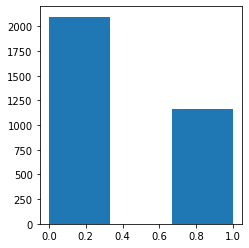

In [67]:
def generate_submission(model, loader, classifier=None, device='cuda:0', mode=0):
    
    if classifier != None:
        classifier.to(device)
        classifier.eval()
    
    model.to(device)
    model.eval()
    
    #df = pd.DataFrame(columns=['id', 'target', 'tokens'])
    df = pd.DataFrame(columns=['id', 'target']) 
    
    for batch in loader:
        with torch.no_grad():
            if mode == 0:
                cls_logits = get_sentence_embeddings(model, batch)
                logits = torch.cat((cls_logits, batch['keyword']), dim=1)
                #print(logits)
                logits = classifier(logits) 
            elif mode == 1:
                cls_logits = get_sentence_pooler_output(model, batch)
                logits = torch.cat((cls_logits, batch['keyword']), dim=1)
                logits = classifier(logits)
            elif mode == -1:
                logits = model(batch['input_ids'], batch['attention_mask']).logits[:,0]                             # get logits
            
         
        prob = F.softmax(logits, -1)                                        # get log-SoftMax
        prob = torch.argmax(prob, -1)                                       # get argMax
        prob = prob.detach().cpu().tolist()                                 # to cpu
        
        ids = batch['id']
        #print(ids)
        for i in range(len(prob)):
            #df = df.append({'id': batch['id'][i], 'target':  prob[i], 'tokens': batch['tokens'][i]}, ignore_index=True)
            df = df.append({'id': int(batch['id'][i]), 'target':  int(prob[i])}, ignore_index=True)
            df.to_csv("submission1.csv", index=False);
    
    return df

# df = generate_submission(bertweet, test_dataloader, classifier=tweet_classifier, device='cuda:0', mode=1)

#df = generate_submission(bertweet, test_dataloader, classifier=classifier, device='cuda:1', mode=1)

#df = generate_submission(tweet_mlm_model, test_dataloader, classifier=mlm_classifier, device='cuda:1', mode=0)

df = generate_submission(pretrain_bert, test_dataloader, classifier=pretrain_classifier, device='cuda:1', mode=1)

# df = generate_submission(mlm_model, test_dataloader,classifier=pt_classifier, device='cuda:0', mode=0)

# df = generate_submission(model, test_dataloader, device='cuda:0', mode=-1)
# df

# df = generate_submission(model, test_dataloader, classifier=ft_classifier, device='cuda:0', mode=0)
# df


print(len(df))
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(df["target"], bins=3
);

## Experiments

### 1.1 Roberta + Classifier With Features--> ( Pretrained)

In [11]:
# eval train 
scores = eval_model(tweet_mlm_model, train_dataloader, mlm_classifier, device='cuda:1', mode=0)
print(scores)

# eval test
scores = eval_model(tweet_mlm_model, eval_dataloader, mlm_classifier, device='cuda:1', mode=0)
print(scores)

print("\nKaggle Submission = ")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:08<00:00, 19.67it/s]


{'accuracy': 0.8219339622641509, 'f1_score': 0.8092564982286309, 'recall': 0.727874060734479, 'precision': 0.8344117250398283}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 20.01it/s]

{'accuracy': 0.8044871794871795, 'f1_score': 0.7900568806879399, 'recall': 0.6937417555630225, 'precision': 0.8230141318376613}

Kaggle Submission = 


### 1.2 Roberta + Classifier With Features--> ( NO Pretraining/Finetuning)

In [110]:
# eval train 
scores = eval_model(bertweet, train_dataloader, classifier, device='cuda:1', mode=1)
print(scores)

# eval test
scores = eval_model(bertweet, eval_dataloader, classifier, device='cuda:1', mode=1)
print(scores)

print("\nKaggle Submission = 0.811") 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 29.42it/s]


{'accuracy': 0.8417845911949685, 'f1_score': 0.8296289380890545, 'recall': 0.7383061208532906, 'precision': 0.872440625509584}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.47it/s]

{'accuracy': 0.8253205128205128, 'f1_score': 0.8125885646473553, 'recall': 0.7268118936953779, 'precision': 0.8457603914810988}

Kaggle Submission = 0.811


### 1.1 Roberta --> Classifier + Pooler Fintuned

In [66]:
# eval train 
scores = eval_model(pretrain_bert, train_dataloader, pretrain_classifier, device='cuda:1', mode=1)
print(scores)

# eval test
scores = eval_model(pretrain_bert, eval_dataloader, pretrain_classifier, device='cuda:1', mode=1)
print(scores)

print("\nKaggle Submission = ") #0.81397

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 28.62it/s]


{'accuracy': 0.8415880503144654, 'f1_score': 0.8294478741968186, 'recall': 0.7377115197869915, 'precision': 0.8731868035310117}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 29.40it/s]

{'accuracy': 0.8253205128205128, 'f1_score': 0.8125834557170234, 'recall': 0.7268118936953779, 'precision': 0.8456782087066084}

Kaggle Submission = 


### 1.1 Roberta with difficult classifier --> ( Pretrained)

In [12]:
# eval train 
scores = eval_model(tweet_mlm_model, train_dataloader, mlm_classifier, device='cuda:1', mode=0)
print(scores)

# eval test
scores = eval_model(tweet_mlm_model, eval_dataloader, mlm_classifier, device='cuda:1', mode=0)
print(scores)

print("\nKaggle Submission = ")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:08<00:00, 19.15it/s]


{'accuracy': 0.9803459119496856, 'f1_score': 0.9789238945453096, 'recall': 0.9711110592280637, 'precision': 0.9825549186325224}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:03<00:00, 19.52it/s]

{'accuracy': 0.7868589743589743, 'f1_score': 0.7754212582329939, 'recall': 0.7296020449300993, 'precision': 0.7612725633147163}

Kaggle Submission = 


### 1.2 Classifier on Masked LM

In [6]:
# eval train 
scores = eval_model(mlm_model, train_dataloader, pt_classifier, device='cuda:0', mode=0)
print(scores)

# eval test
scores = eval_model(mlm_model, eval_dataloader, pt_classifier, device='cuda:0', mode=0)
print(scores)

print("\nKaggle Submission = 0.79190")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 29.71it/s]


{'accuracy': 0.820558176100629, 'f1_score': 0.8073154885930385, 'recall': 0.7262527786419369, 'precision': 0.8290266299342473}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.97it/s]

{'accuracy': 0.7984775641025641, 'f1_score': 0.7858087014011298, 'recall': 0.7206957457240263, 'precision': 0.7864180241159879}

Kaggle Submission = 0.79190


### 1.2 Classifier on Masked LM with 2 layer classifier

In [9]:
# eval train 
scores = eval_model(mlm_model, train_dataloader, hard_classifier, device='cuda:0', mode=0)
print(scores)

# eval test
scores = eval_model(mlm_model, eval_dataloader, hard_classifier, device='cuda:0', mode=0)
print(scores)

print("\nKaggle Submission = ?")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:05<00:00, 29.53it/s]


{'accuracy': 0.8142688679245284, 'f1_score': 0.8026564441353563, 'recall': 0.7658367613643915, 'precision': 0.7877552349286971}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 28.85it/s]

{'accuracy': 0.7552083333333334, 'f1_score': 0.7444898056937154, 'recall': 0.7368608390101603, 'precision': 0.700531902407349}

Kaggle Submission = ?


### 1.3 Classifier on Finetuned Model

In [26]:
# eval train 
scores = eval_model(model, train_dataloader, device='cuda:0', mode=-1)
print(scores)

# eval test
scores = eval_model(mlm_model, eval_dataloader, device='cuda:0', mode=-1)
print(scores)

print("\nKaggle Submission = ?")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:04<00:00, 33.97it/s]


{'accuracy': 0.9950864779874213, 'f1_score': 0.994837141634972, 'recall': 0.9910934838376569, 'precision': 0.9976969571309194}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:02<00:00, 33.16it/s]

{'accuracy': 0.7852564102564102, 'f1_score': 0.774424757256912, 'recall': 0.7496951431340572, 'precision': 0.7480851110093192}

Kaggle Submission = ?


# Experiments

### 1.1 Binary Cassifer with features [ ROBERTA ] BASELINE: 

##### Load  Binary Classifier with Features  [ ROBERTA ]

In [109]:
classifier = BinClassifierWithFeatures()     # define model

classifier.load_state_dict(torch.load('nlp-getting-started/weights/text_classifier.pth'))           # load weights

<All keys matched successfully>

##### Train Binary Classifier with Features  [ ROBERTA ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [17:43<00:00,  5.32s/it]

min loss value 0.3746858341326504


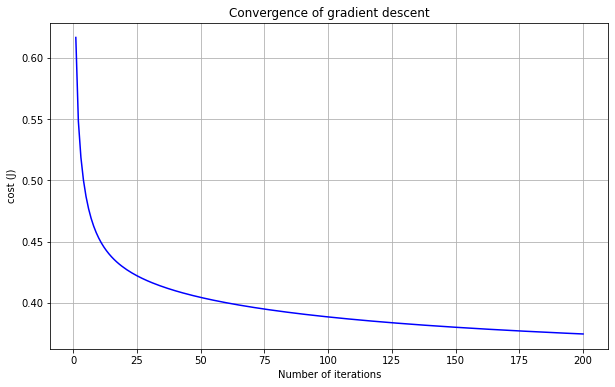

In [16]:
classifier =  BinClassifierWithFeatures()

train_loss = train_bin_class(classifier, bertweet, train_dataloader, num_epochs=200, device='cuda:1', pooler=True)

torch.save(classifier.state_dict(), 'nlp-getting-started/weights/text_classifier.pth')

convergence_graph(train_loss)       # min loss = 0.4438683907003523

### 1.2 Pretraining  on Roberta
- Using Masked LM objective on Roberta (no finetuning)


##### Load Roberta MLM + Classifier

In [311]:
# Load Roberta MLM Model

tweet_mlm_model = deepcopy(bertweet)

tweet_mlm_model.pooler = roberta_mlm.lm_head

tweet_mlm_model.pooler.decoder = nn.Linear(768, len(tokenizer.get_vocab()))                                                                               # define model

tweet_mlm_model.load_state_dict(torch.load('nlp-getting-started/weights/pretrained_roberta.pth'))           # load weights


#Load Binary Classifier

mlm_classifier = BinClassifierWithFeatures()     # define model

mlm_classifier.load_state_dict(torch.load('nlp-getting-started/weights/mlm_classifier.pth'))           # load weights

<All keys matched successfully>

##### Train Roberta MLM

In [42]:
def roberta_pretrain(model, loader, num_epochs=10, device='cuda:1'):
    model.to(device)
    model.train() 
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    cc = nn.CrossEntropyLoss()
    
    train_loss = []
    avg_batch_loss = []
    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in loader:
            batch = apply_mask(batch, device='cuda:1')
            outputs = model(input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask'],
                        token_type_ids=batch['token_type_ids']
                       ).pooler_output
            
            outputs = torch.transpose(outputs, 2, 1)
            labels = batch['labels']
            #print(labels.shape)
            #print(outputs.shape)
            
            loss = cc(outputs, labels)
            #print(loss)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            avg_batch_loss.append(loss.item())
        
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        train_loss.append(avg)      
    
    return train_loss

In [ ]:
#### Roberta MLM Model

tweet_mlm_model = deepcopy(bertweet)

tweet_mlm_model.pooler = roberta_mlm.lm_head

tweet_mlm_model.pooler.decoder = nn.Linear(768, len(tokenizer.get_vocab()))


## check forrward pass
"""
tweet_mlm_model.to('cuda:1')

with torch.no_grad():
    kk = tweet_mlm_model(input_ids=train_batch['input_ids'], 
                 attention_mask=train_batch['attention_mask'], 
                 token_type_ids=train_batch['token_type_ids']).pooler_output.shape
print(kk)

"""

train_loss = roberta_pretrain(tweet_mlm_model, full_data_loader, num_epochs=300)

torch.save(tweet_mlm_model.state_dict(), 'nlp-getting-started/weights/pretrained_roberta.pth')

convergence_graph(train_loss)  # min loss = 0.06914102886894755

  1%|██▎                                                                                                                                                                                                                                      | 3/300 [03:54<6:27:06, 78.20s/it]

min loss value 0.37822234527494925


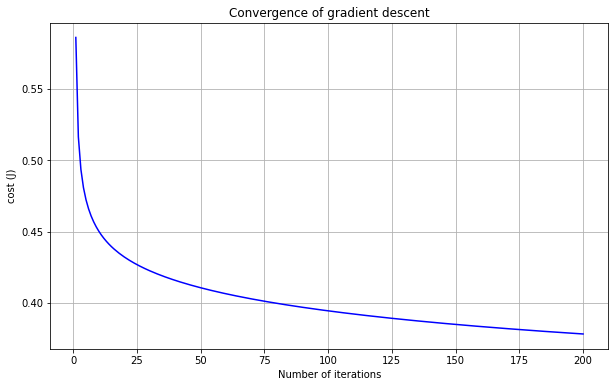

In [49]:
convergence_graph(train_loss)

##### Train Binary Classifier with Extra Features on Roberta

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [03:21<00:00,  8.08s/it]

min loss value 0.42693398208738126


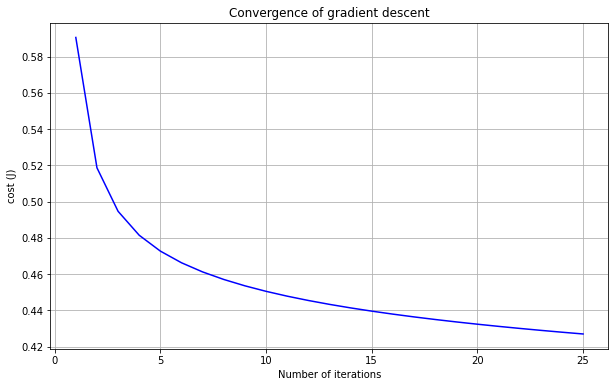

In [8]:
#tweet_mlm_model.pooler = bertweet.pooler

mlm_classifier = BinClassifierWithFeatures()

train_loss = train_bin_class(mlm_classifier, tweet_mlm_model, train_dataloader, num_epochs=25, device='cuda:1', pooler=False)

torch.save(mlm_classifier.state_dict(), 'nlp-getting-started/weights/mlm_classifier.pth')

convergence_graph(train_loss)       # min loss = 0.3895701692914063

In [ ]:
# 3369, 3398, 4966, 6654 in file train.csv.

### 1.3 Finetune on Pooler and classifier

In [35]:
def train(classifier, model, dataloader, pooler, num_epochs=10, device='cuda:1', lr=0.001):
    classifier.to(device)
    classifier.train()
    pooler.train()
    
    model.to(device)
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=lr)
    train_loss = []
    
    #wandb.init(project="kaggle_nlp", name="binary_classifier")
    
    for epoch in tqdm(range(num_epochs)):
        avg_batch_loss = []
        for batch in dataloader: 
            labels = torch.tensor(batch['target']).to(device)

            with torch.no_grad():
                cls_logits = model(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"]).pooler_output
                
            with torch.enable_grad():
                cls_logits = pooler_layer(cls_logits)
                
            
            logits = torch.cat((cls_logits, batch['keyword']), dim=1)
            logits = classifier(logits)
            
            loss = criterion(logits, torch.squeeze(labels.T))
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            avg_batch_loss.append(loss.item())
            
        avg = sum(avg_batch_loss) / len(avg_batch_loss)
        #loss_dict = {'train_loss': loss.item()}
        #wandb.log(loss_dict, step=epoch)
        train_loss.append(avg)
    
    #wandb.finish()
    return train_loss

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:23<00:00,  5.26s/it]

min loss value 0.3737629901313182


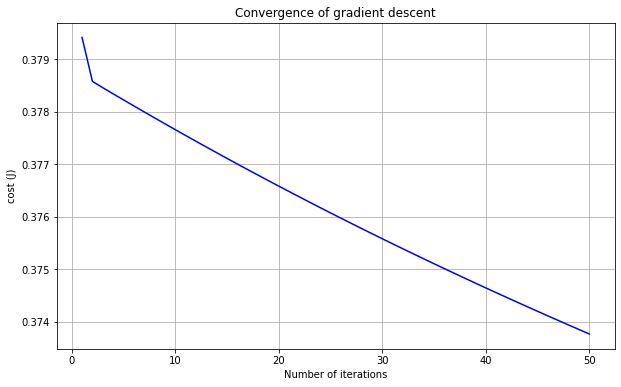

In [65]:
class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
    

pretrain_classifier = BinClassifierWithFeatures()     
    
bertweet.to('cuda:1')

pretrain_bert = deepcopy(bertweet) 

pooler_layer = deepcopy(bertweet.pooler)
 
pretrain_bert.pooler = Identity()

train_loss = train(pretrain_classifier, pretrain_bert, train_dataloader, pooler_layer, num_epochs=50, device='cuda:1', lr=0.001)

pretrain_bert.pooler = pooler_layer

convergence_graph(train_loss)

### 1.2 Pretraining  on BERTMLM
- Using Masked LM objective on Bert Model (no finetuning)
- Load Model

In [5]:
# Load MLM Model

mlm_model = BertForMaskedLM.from_pretrained('bert-base-uncased')                                                                                 # define model

mlm_model.load_state_dict(torch.load('nlp-getting-started/weights/mlm_model.pth'))           # load weights

mlm_model.to('cuda:0')

# Load MLM classifier model

pt_classifier = BinClassifier()                                                                      # define model

pt_classifier.load_state_dict(torch.load('nlp-getting-started/weights/pt_classifier.pth'))           # load weights

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [46:59<00:00, 14.10s/it]


min loss value 0.021383057179513807


wandb: Currently logged in as: paul_shab (use `wandb login --relogin` to force relogin)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:50<00:00,  5.31s/it]


train_loss,0.32315
_runtime,532
_timestamp,1629291235
_step,99


train_loss,█▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


min loss value 0.40889642635981244


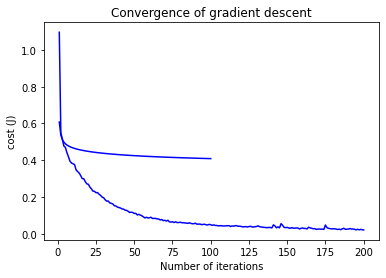

In [5]:
# Train MLM Model

train_loss1 = pretrain_masked_lm(mlm_model, test_dataloader, num_epochs=100, device='cuda:0')

torch.save(mlm_model.state_dict(), 'nlp-getting-started/weights/mlm_model.pth')

convergence_graph(train_loss1)   # min loss = 0.021383057179513807



# Train MLM Binary Classifier Model

pt_classifier = BinClassifier()

train_loss = train_bin_class(pt_classifier, "mlm_classifier3",  mlm_model, train_dataloader, num_epochs=100, device='cuda:0')

torch.save(pt_classifier.state_dict(), 'nlp-getting-started/weights/pt_classifier.pth')

convergence_graph(train_loss)   # min loss = 0.39946962527509006

# SKLEARN Composition Models

In [74]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

results_accuracy = pd.DataFrame(0.0,
                                columns=['No composition', 'Dummy', 'Bagging', 'Bagging_mf', 'AdaBoost'],
                                index=['DTC', 'DTC-1', 'LR', 'SVC'])

In [277]:
def eval_data(clf, model, loader):
    model.eval()
    scores = []
    for batch in loader:
        labels = torch.tensor(batch['target'])
        
        with torch.no_grad():
            cls_logits = model(input_ids=batch["input_ids"],
                              token_type_ids=batch["token_type_ids"],
                              attention_mask=batch["attention_mask"]).pooler_output
        logits = torch.cat((cls_logits, batch['keyword']), dim=1).cpu()
        pred = clf.predict(logits)
        scores.append(f1_score(labels, pred))
    
    scores = np.array(scores)                 
    return np.mean(scores), np.std(scores)

def eval_train(clf, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

def eval_train2(clf, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

def generate_csv(labels, ids, name="submission2.csv"):
    df = pd.DataFrame(columns=['id', 'target']) 
    for i in range(len(labels)):
        df = df.append({'id': int(ids[i]), 'target':  int(labels[i])}, ignore_index=True)
        df.to_csv(name, index=False);
    return df
    

In [269]:
def get_tensor(model, loader, include_labels=True):
    model.eval()
    X = torch.tensor([])
    y = torch.tensor([])
    
    for batch in loader: 
        if include_labels:
            labels = torch.tensor(batch['target'])  
        else:
            labels = torch.tensor(batch['id'], dtype=torch.int32)
            
    
        with torch.no_grad():
            cls_logits = model(input_ids=batch["input_ids"],
                              token_type_ids=batch["token_type_ids"],
                              attention_mask=batch["attention_mask"]).pooler_output
        
        logits = torch.cat((cls_logits, batch['keyword']), dim=1).cpu()
        X = torch.cat([X, logits], dim=0)
        y = torch.cat([y, labels], dim=0)
        
        
    return X, y

X, y = get_tensor(bertweet, eval_train_dataloader)
print(X.shape)
print(y.shape)

train_X, train_y = get_tensor(bertweet, train_dataloader)
print("\n", train_X.shape)
print(train_y.shape)

eval_X, eval_y = get_tensor(bertweet, eval_dataloader)
print("\n", eval_X.shape)
print(eval_y.shape)

test_X, y_id = get_tensor(bertweet, test_dataloader, include_labels=False)
print("\n", test_X.shape)
print(y_id.shape)

torch.Size([7613, 793])
torch.Size([7613])

 torch.Size([5088, 793])
torch.Size([5088])

 torch.Size([2496, 793])
torch.Size([2496])

 torch.Size([3263, 793])
torch.Size([3263])


In [313]:
bertweet.pooler

RobertaPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [312]:
.pooler

RobertaLMHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (decoder): Linear(in_features=768, out_features=64001, bias=True)
)

### Logitsic Regression

In [300]:
log_reg = LogisticRegression(max_iter=1000)

acc_mean, acc_std = eval_train(log_reg, X, y)
results_accuracy.loc['LR', 'No composition'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")  

log_reg.fit(X, y)

pred_test = log_reg.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission11.csv")

# Kaggle Score ---> 0.81581

cross vall acc: 0.78, 0.01


### Decision Tree

In [301]:
dec_tree = DecisionTreeClassifier()

acc_mean, acc_std = eval_classifier(dec_tree, X, y)  

results_accuracy.loc['DTC', 'No composition'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")

dec_tree.fit(X, y)

pred_test = log_reg.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission12.csv")

cross vall acc: 0.67, 0.02


### Decision Tree Modifed

In [302]:
dec_tree_mf = DecisionTreeClassifier(max_depth=1)

acc_mean, acc_std = eval_classifier(dec_tree_mf, X, y)

results_accuracy.loc['DTC-1', 'No composition'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")

dec_tree_mf.fit(X, y)

pred_test = dec_tree_mf.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission13.csv")

cross vall acc: 0.66, 0.02


### SVM

In [303]:
# *
svm = SVC(probability=True)

acc_mean, acc_std = eval_classifier(svm, X, y)

results_accuracy.loc['SVC', 'No composition'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")

svm.fit(X, y)

pred_test = svm.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission14.csv")

# Kaggle Score ---> 

cross vall acc: 0.80, 0.01


In [276]:
results_accuracy

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.664737,0.000000,0.000000,0.0,0.0
DTC-1,0.700469,0.000000,0.000000,0.0,0.0
LR,0.779796,0.814856,0.813284,0.0,0.0
SVC,0.804982,0.000000,0.000000,0.0,0.0


# Ensamble Model

In [246]:
from sklearn import base

class DummyEnsemble(object):
    def __init__(self, base_estimator, n_estimators=10):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator            
        self._bs = [base.clone(self.base_estimator) for _ in range(self.n_estimators)]
        
    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 
                'base_estimator': self.base_estimator}
        
    def fit(self, X, Y):
        for b in self._bs:
            b.fit(X, Y)
            
    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)
    
    def predict_proba(self, X):
        return np.mean([b.predict_proba(X) for b in self._bs], axis=0)

### Logistic Regression

In [291]:
log_reg_ensamble = DummyEnsemble(LogisticRegression(max_iter=1000))

acc_mean, acc_std = eval_classifier(log_reg_ensamble, X, y)

results_accuracy.loc['LR', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

log_reg_ensamble.fit(X, y)

pred_test = log_reg_ensamble.predict(test_X)
generate_csv(pred_test, y_id, name="submission2.csv")

# Kaggle Score ---> 0.81428

0.82, 0.01


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### SVM

In [295]:
# *
svm_ensamble = DummyEnsemble(SVC(probability=True))

acc_mean, acc_std = eval_classifier(svm_ensamble, X, y)

results_accuracy.loc['SVC', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

svm_ensamble.fit(X, y)

pred_test = svm_ensamble.predict(test_X)
generate_csv(pred_test, y_id, name="submission21.csv")

# Kaggle Score ---> 

0.80, 0.01


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### Decison Tree

In [296]:
# *
dec_tree = DummyEnsemble(DecisionTreeClassifier(), n_estimators=10)

acc_mean, acc_std = eval_classifier(dec_tree, X, y)

results_accuracy.loc['DTC', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

dec_tree.fit(X, y)

pred_test = dec_tree.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission22.csv")

# Kaggle Score ---> 

0.68, 0.02


### Decision Tree 1

In [297]:
# *
dec_tree_ensamble = DummyEnsemble(DecisionTreeClassifier(max_depth=1))

acc_mean, acc_std = eval_classifier(dec_tree_ensamble, X, y)

results_accuracy.loc['DTC-1', 'Dummy'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

dec_tree_ensamble.fit(X, y)

pred_test = dec_tree_ensamble.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission23.csv")

# Kaggle Score ---> 

0.66, 0.02


# Bagging

### Bagging Logistic Regression

In [290]:
from sklearn.ensemble import BaggingClassifier

bag_log_reg = BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, max_samples=1.0, 
                      max_features=1.0, bootstrap=True, bootstrap_features=False)

acc_mean, acc_std = eval_classifier(bag_log_reg, X, y)

results_accuracy.loc['LR', 'Bagging'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")

bag_log_reg.fit(X, y)

pred_test = bag_log_reg.predict(test_X)
generate_csv(pred_test, y_id, name="submission1.csv")

# Kaggle Score ---> 0.81458

cross vall acc: 0.82, 0.01


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### Modified Bagging Logistic Regression

In [314]:
bag_log_reg_mf = BaggingClassifier(LogisticRegression(max_iter=1000), n_estimators=10, max_samples=1.0, 
                      max_features=0.8, bootstrap=True, bootstrap_features=False)

acc_mean, acc_std = eval_classifier(bag_log_reg_mf, X, y)

results_accuracy.loc['LR', 'Bagging_mf'] = acc_mean
print("cross vall acc:", f"{acc_mean:.2f}, {acc_std:.2f}")

bag_log_reg_mf.fit(X, y)

pred_test = bag_log_reg_mf.predict(test_X)
generate_csv(pred_test, y_id, name="submission5.csv")
print()

# Kaggle Score ---> 0.81366

cross vall acc: 0.82, 0.01



### Bagging SVM

In [285]:
bag_svm = BaggingClassifier(SVC(probability=True))

acc_mean, acc_std = eval_classifier(bag_svm, X, y)

results_accuracy.loc['SVC', 'Bagging'] = acc_mean
print("\ncross vall acc:", f"{acc_mean:.3f}, {acc_std:.3f}")

bag_svm.fit(X, y)

pred_test = bag_svm.predict(test_X)
generate_csv(pred_test, y_id, name="submission5.csv")
print()

# Kaggle Score ---> 0.79650

[1. 1. 1. ... 1. 1. 1.]

train:  0.8012542209358418
eval:  0.780561122244489

cross vall acc: 0.804, 0.013


### Bagging Decision Tree

In [298]:
# *
bagging_dec_tree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_samples=1.0, 
                      max_features=1.0, bootstrap=True, bootstrap_features=False)

acc_mean, acc_std = eval_classifier(bagging_dec_tree, X, y)

results_accuracy.loc['DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

bagging_dec_tree.fit(X, y)

pred_test = bagging_dec_tree.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission31.csv")

# Kaggle Score ---> 

0.74, 0.01


### Modified Bagging Decision Tree

In [304]:
# *
mf_bagging_dec_tree =BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_samples=1.0, 
                      max_features=0.8, bootstrap=True, bootstrap_features=False)

acc_mean, acc_std = eval_classifier(mf_bagging_dec_tree, X, y)

results_accuracy.loc['DTC', 'Bagging_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

mf_bagging_dec_tree.fit(X, y)

pred_test = mf_bagging_dec_tree.predict(test_X)
df = generate_csv(pred_test, y_id, name="submission32.csv")

0.75, 0.01


In [309]:
results_accuracy

,No composition,Dummy,Bagging,Bagging_mf,AdaBoost
DTC,0.669598,0.676605,0.743202,0.747231,0.0
DTC-1,0.657428,0.657428,0.000000,0.000000,0.0
LR,0.779796,0.822278,0.823109,0.000000,0.0
SVC,0.804982,0.802311,0.804062,0.000000,0.0
